# Physics-Driven Visualizations: Defect Impact on Metasurface Spectra

This notebook generates high-quality, physics-first figures for the manuscript. 
It focuses on visualizing the physical reality of defects (using real microscope images) and their spectral consequences.

## Figures Generated:
1. **Measurement Window Visualization**: Real 9x9 pillar images showing Nominal, High Impact, and High Density cases.
2. **Defect Replacement Experiment**: Synthetic arrangement test (Clustered vs Aligned vs Dispersed).
3. **Radial Influence**: Impact of defect proximity.
4. **Macroscopic Fields**: Array-wide defect and impact maps.
5. **Model Validation**: Physics-feature parity plot.

In [1]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import cv2

# Determine Project Root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from defect_analysis.ml import ftir_utils, dataset_assembly, ml_models

# Styling
plt.rcParams.update({
    "figure.dpi": 150,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.facecolor": "white",
    "axes.grid": False
})

# Color palette (Colorblind safe)
COLORS = {
    "Good": "#d9d9d9",       # Light Gray
    "Missing": "#ffffff",    # White (Empty)
    "Collapsed": "#d62728",  # Red
    "Irregular": "#ff7f0e",  # Orange
    "Stitching": "#1f77b4",  # Blue
    "Measurement": "#2ca02c" # Green (Overlay)
}

OUTPUT_DIR = os.path.join(PROJECT_ROOT, "ml_outputs", "physics_visuals")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\ml_outputs\physics_visuals


## 1. Data Loading & Preparation
We load the dataset and force a rebuild to ensure alignment with the latest codebase.

In [2]:
# Load Pre-computed Regression Dataset
dataset_path = os.path.join(PROJECT_ROOT, "ml_outputs", "regression_dataset.csv")

# FORCE REBUILD
print("Forcing dataset rebuild...")
FTIR_DIR = os.path.join(PROJECT_ROOT, "data")
CSV_PATH = os.path.join(PROJECT_ROOT, "results", "meta_atoms_classified.csv")
array_data = ftir_utils.load_all_arrays(FTIR_DIR)
classifications = ftir_utils.load_classifications(CSV_PATH)

df, _ = dataset_assembly.build_master_dataset(array_data, classifications)

# Handle NaNs for distance features
dist_fill = {
    'min_defect_dist': 999.0,
    'mean_defect_dist': 999.0,
    'sum_1_over_dist': 0.0
}
df.fillna(dist_fill, inplace=True)

print(f"Rebuilt dataset: {len(df)} rows")

Forcing dataset rebuild...
  Assembling Array_1.0 ...
    Processed 169 measurements.
  Assembling Array_2.0 ...
    Processed 169 measurements.
  Assembling Array_3.0 ...
    Processed 169 measurements.
Rebuilt dataset: 507 rows


## 2. Real Image Measurement Window (Figure 1)
Visualizing exactly what the FTIR "sees" by stitching together real microscope pillars.

Using wavelength shift column: delta_peak_wl


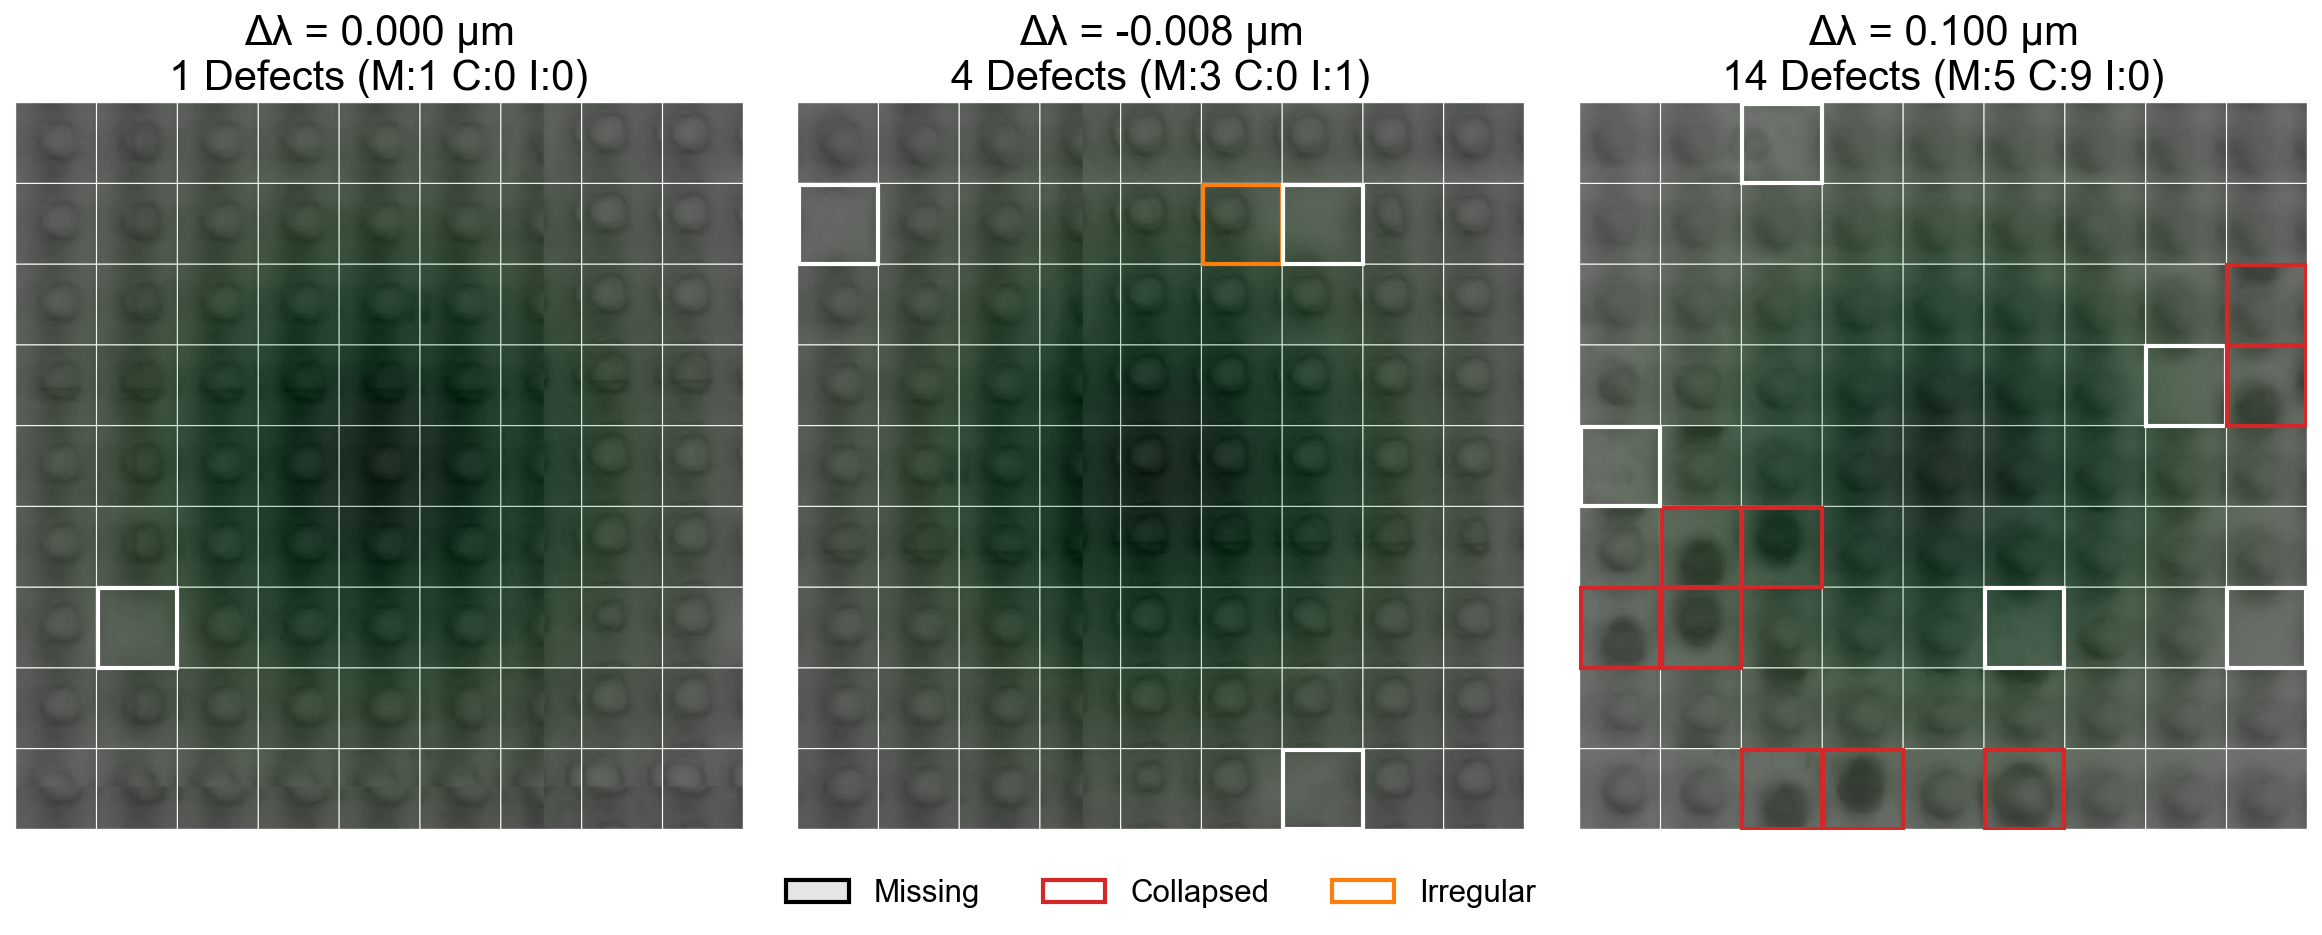

In [30]:
# ============================================================
# FULL REWRITE — 9x9 Windows with Physics-Aware Selection
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

# ------------------------------------------------------------
# Auto-detect wavelength shift column
# ------------------------------------------------------------

possible_cols = [
    "delta_peak_wl",
    "delta_peak_lambda",
    "delta_lambda",
    "delta_peak",
    "peak_shift",
    "delta_peak_loc"
]

shift_col = None
for col in possible_cols:
    if col in df.columns:
        shift_col = col
        break

if shift_col is None:
    raise ValueError("No wavelength shift column found. Check df.columns.")

print(f"Using wavelength shift column: {shift_col}")


# ------------------------------------------------------------
# Compute Local 9x9 Defects
# ------------------------------------------------------------

def compute_local_defects(df_row, pillar_map, window_half=4):
    center_row = int(df_row["global_row"])
    center_col = int(df_row["global_col"])

    counts = {"Missing": 0, "Collapsed": 0, "Irregular": 0}

    for (r, c), dtype in pillar_map.items():
        if abs(r - center_row) <= window_half and \
           abs(c - center_col) <= window_half:
            if dtype in counts:
                counts[dtype] += 1

    return counts, sum(counts.values())


# ------------------------------------------------------------
# Build Local Dataset
# ------------------------------------------------------------

window_half = 4
records = []

for idx, row in df.iterrows():

    array_name = row["array"]
    map_name = ftir_utils.DPT_TO_CSV_NAME.get(array_name, None)
    pillar_map = classifications.get(map_name, {})

    local_counts, total_local = compute_local_defects(row, pillar_map)

    records.append({
        "index": idx,
        "abs_shift": abs(row[shift_col]),
        "local_total": total_local,
        "Missing": local_counts["Missing"],
        "Collapsed": local_counts["Collapsed"],
        "Irregular": local_counts["Irregular"]
    })

df_local = pd.DataFrame(records)


# ------------------------------------------------------------
# Physics-Aware Cherry Picking
# ------------------------------------------------------------

# 1️⃣ True nominal: ≤1 defect, lowest shift
nominal = df_local[
    df_local["local_total"] <= 1
].sort_values("abs_shift").iloc[0]

# 2️⃣ Sparse but strong impact (1–4 defects, high shift)
sparse_high = df_local[
    (df_local["local_total"] >= 1) &
    (df_local["local_total"] <= 4)
].sort_values("abs_shift", ascending=False).iloc[0]

# 3️⃣ Dense + high impact (top 10% density)
dense_threshold = df_local["local_total"].quantile(0.90)

dense_high = df_local[
    df_local["local_total"] >= dense_threshold
].sort_values("abs_shift", ascending=False).iloc[0]

examples = [
    df.loc[nominal["index"]],
    df.loc[sparse_high["index"]],
    df.loc[dense_high["index"]]
]


# ------------------------------------------------------------
# Stitching Function
# ------------------------------------------------------------

def stitch_window_image(df_row, pillar_map, border_size=1, window_half=4):

    center_row = int(df_row["global_row"])
    center_col = int(df_row["global_col"])
    array_name = df_row["array"]

    sample = load_pillar_tile(array_name, center_row, center_col)
    h, w = sample.shape
    grid_size = 2 * window_half + 1

    montage_h = (h + border_size) * grid_size + border_size
    montage_w = (w + border_size) * grid_size + border_size
    montage = np.full((montage_h, montage_w), 255, dtype=np.uint8)

    overlays = []

    for dr in range(-window_half, window_half + 1):
        for dc in range(-window_half, window_half + 1):

            r = center_row + dr
            c = center_col + dc

            grid_r = window_half - dr
            grid_c = dc + window_half

            tile = load_pillar_tile(array_name, r, c)
            if tile.shape != (h, w):
                tile = cv2.resize(tile, (w, h))

            y0 = border_size + grid_r * (h + border_size)
            x0 = border_size + grid_c * (w + border_size)

            montage[y0:y0+h, x0:x0+w] = tile

            defect_type = pillar_map.get((r, c), "Good")
            if defect_type in ["Missing", "Collapsed", "Irregular"]:
                overlays.append((x0, y0, w, h, COLORS[defect_type]))

    return montage, overlays


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.rcParams.update({
    "font.size": 24,
    "axes.titlesize": 100,
    "axes.labelsize": 100,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 15
})

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for ax, row in zip(axes, examples):

    array_name = row["array"]
    map_name = ftir_utils.DPT_TO_CSV_NAME.get(array_name, None)
    pillar_map = classifications.get(map_name, {})

    local_counts, total_local = compute_local_defects(row, pillar_map)
    montage, overlays = stitch_window_image(row, pillar_map)

    ax.imshow(montage, cmap="gray")

    # Gaussian beam (restricted clean)
    h_img, w_img = montage.shape
    cy, cx = h_img // 2, w_img // 2
    Y, X = np.ogrid[:h_img, :w_img]
    sigma = h_img * 0.28

    gaussian = np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))
    gaussian = (gaussian - gaussian.min()) / (gaussian.max() - gaussian.min())

    ax.imshow(gaussian, cmap="Greens", alpha=0.25)

    for (x, y, w_box, h_box, color) in overlays:
        rect = patches.Rectangle((x, y), w_box, h_box,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor="none")
        ax.add_patch(rect)

    ax.set_title(
        f"Δλ = {row[shift_col]:.3f} µm\n"
        f"{total_local} Defects "
        f"(M:{local_counts['Missing']} "
        f"C:{local_counts['Collapsed']} "
        f"I:{local_counts['Irregular']})",
        fontsize=20
    )

    ax.axis("off")


# ------------------------------------------------------------
# Legend (Correctly Rendered)
# ------------------------------------------------------------

legend_elements = [
    patches.Patch(facecolor='#e6e6e6', edgecolor='black', label='Missing', linewidth=2),
    patches.Patch(facecolor='none', edgecolor=COLORS['Collapsed'], label='Collapsed', linewidth=2),
    patches.Patch(facecolor='none', edgecolor=COLORS['Irregular'], label='Irregular', linewidth=2),
]

fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=4,
           bbox_to_anchor=(0.5, -0.03),
           frameon=False)

plt.tight_layout()
plt.show()


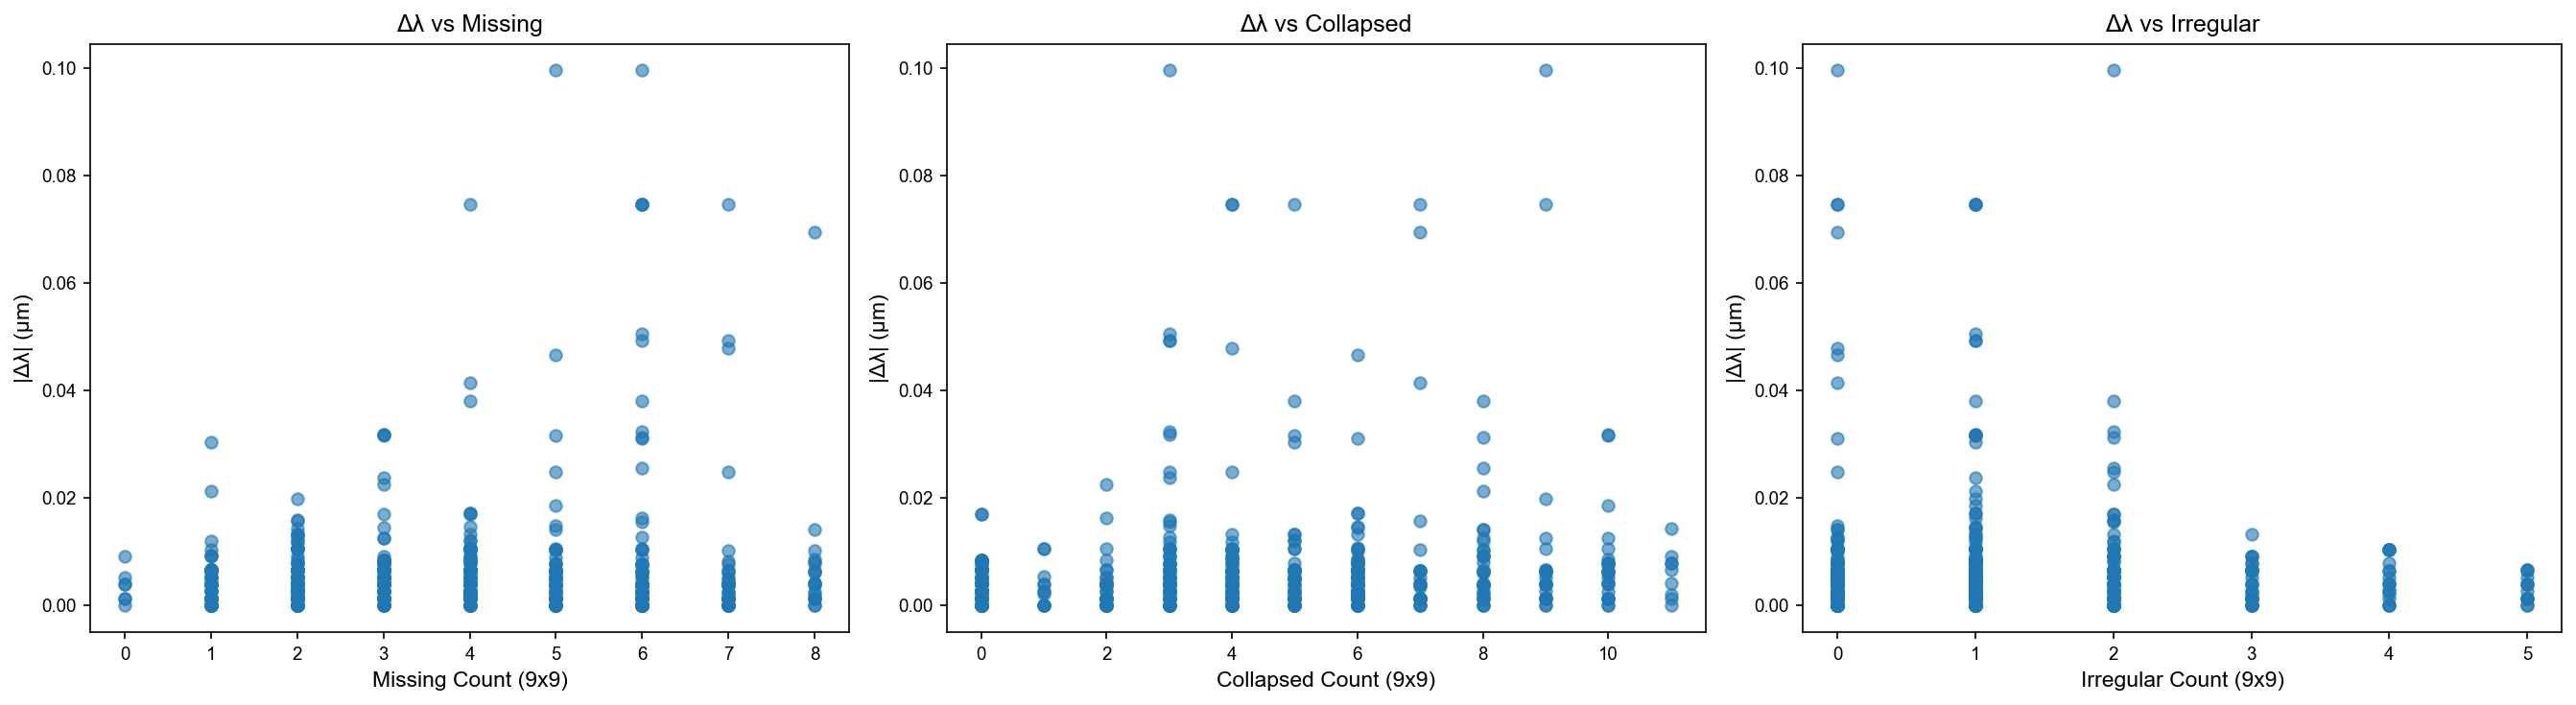

In [23]:
# ============================================================
# Δλ vs Local Defect Count (Window Only)
# ============================================================

window_half = 4
records = []

for _, row in df.iterrows():

    array_name = row["array"]
    map_name = ftir_utils.DPT_TO_CSV_NAME.get(array_name, None)
    pillar_map = classifications.get(map_name, {})

    local_counts, total_local = compute_local_defects(row, pillar_map)

    records.append({
        "abs_shift": abs(row["delta_peak_wl"]),
        "Missing": local_counts["Missing"],
        "Collapsed": local_counts["Collapsed"],
        "Irregular": local_counts["Irregular"]
    })

df_local = pd.DataFrame(records)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, defect in zip(axes, ["Missing", "Collapsed", "Irregular"]):

    ax.scatter(df_local[defect], df_local["abs_shift"], alpha=0.6)
    ax.set_xlabel(f"{defect} Count (9x9)")
    ax.set_ylabel("|Δλ| (µm)")
    ax.set_title(f"Δλ vs {defect}")

plt.tight_layout()
plt.show()


In [16]:
df

,n_missing,n_collapsed,n_stitching,n_irregular,n_total_defects,is_zero_defect,min_defect_dist,mean_defect_dist,sum_1_over_dist,meas_idx,...,raw_peak_wl,raw_peak_mag,peak_prominence,delta_peak_wl,delta_peak_mag_raw,delta_peak_mag,array_id,array,norm_row,norm_col
0,8,7,0,0,15,False,26.832816,42.980325,0.375006,1,...,7.142232,0.621628,0.279668,-0.069544,-0.032081,-0.020638,1,Array_1.0,0.75,-1.000000
1,8,7,0,1,16,False,24.000000,46.267082,0.378593,2,...,7.201751,0.649563,0.290586,-0.004150,-0.009644,-0.003482,1,Array_1.0,0.75,-0.833333
2,8,4,9,1,22,False,24.000000,50.277139,0.478022,3,...,7.221812,0.671166,0.301617,-0.004051,-0.016430,-0.014355,1,Array_1.0,0.75,-0.666667
3,6,2,18,1,27,False,26.832816,48.762619,0.592331,4,...,7.231884,0.702624,0.319014,-0.004051,-0.004835,-0.005651,1,Array_1.0,0.75,-0.500000
4,6,2,18,1,27,False,24.000000,42.844008,0.677207,5,...,7.231884,0.713251,0.321289,-0.016189,-0.010784,-0.013298,1,Array_1.0,0.75,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,5,7,8,2,22,False,12.000000,36.406277,0.730291,165,...,7.450087,0.172732,0.037614,0.006413,-0.022116,-0.010704,3,Array_3.0,-0.75,0.333333
503,6,8,8,2,24,False,0.000000,38.932777,1.506319,166,...,7.450087,0.169419,0.037847,0.038140,-0.021675,-0.007158,3,Array_3.0,-0.75,0.500000
504,6,8,8,2,24,False,0.000000,41.198660,1.484858,167,...,7.365427,0.166224,0.037658,-0.025476,-0.018523,0.000353,3,Array_3.0,-0.75,0.666667
505,6,8,0,2,16,False,12.000000,35.808117,0.562104,168,...,7.334174,0.158236,0.036322,-0.031254,-0.014193,0.010297,3,Array_3.0,-0.75,0.833333


## 2. Defect Replacement Experiment (Figure 2)
Comparing specific synthetic defect arrangements with equal counts but different geometries.

RF Model trained.


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


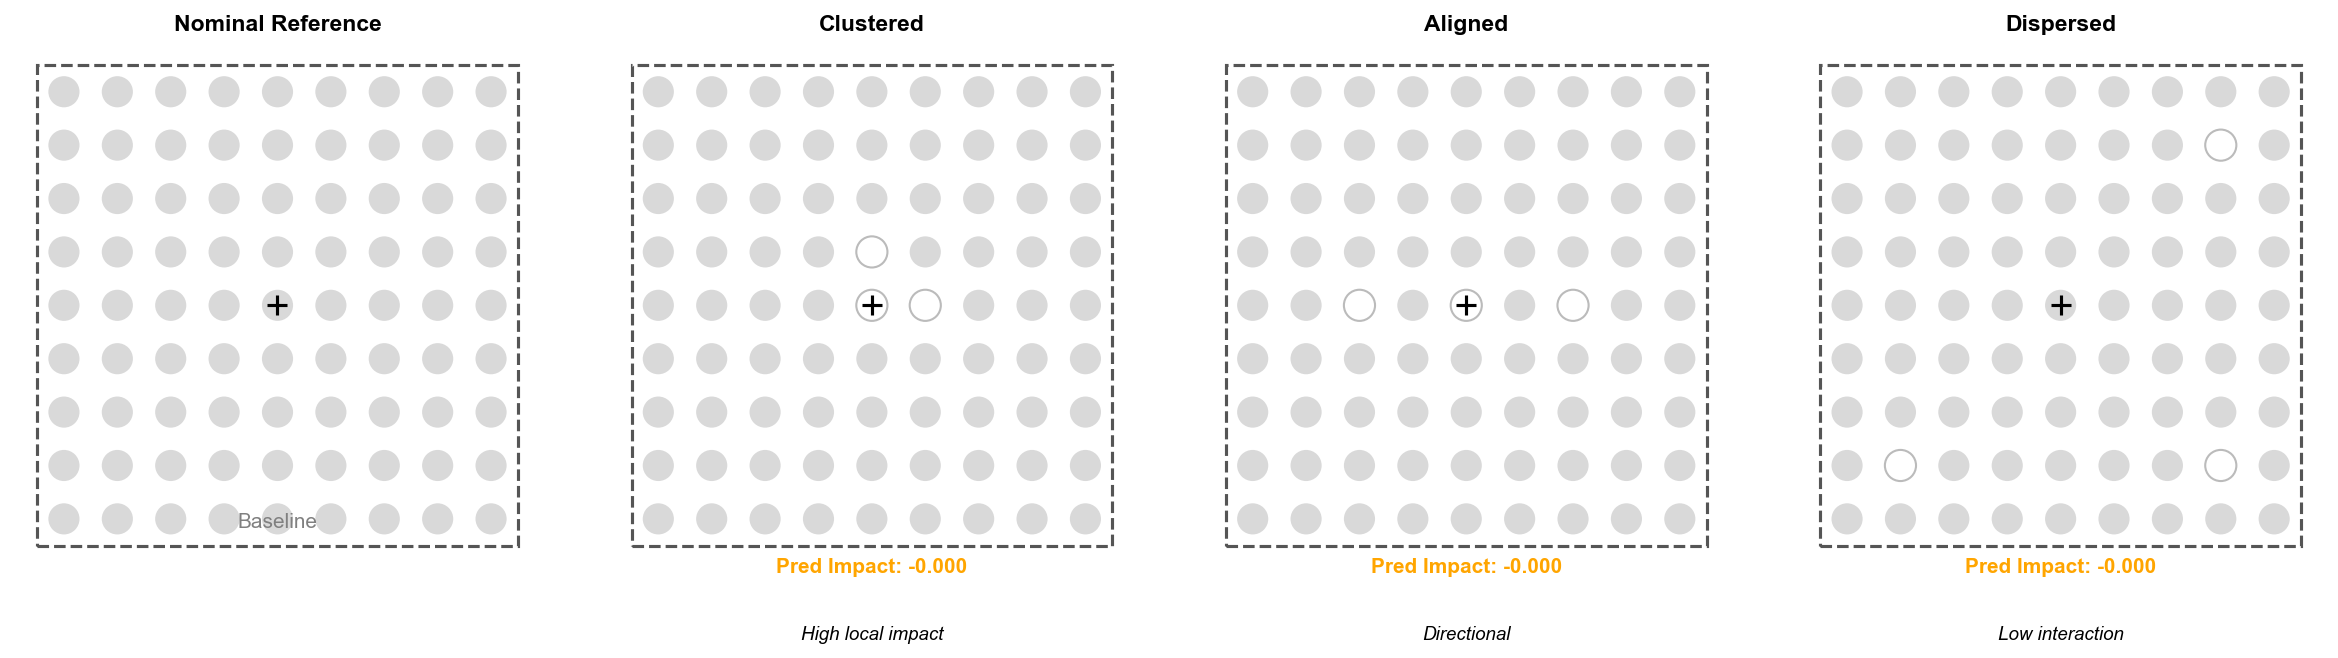

In [4]:
# Train Model first
features_cols = dataset_assembly.INPUT_COLS
target = "delta_peak_mag"
X = df[features_cols]
y = df[target]
rf_model = ml_models.train_rf(X.values, y.values)
print("RF Model trained.")

def plot_window_schematic(ax, center_row, center_col, pillar_map, title=""):
    """Draws the 9x9 pillar grid centered at (center_row, center_col)."""
    window_half = 4
    pitch = 12.0 # um
    extent = [-4.5 * pitch, 4.5 * pitch, -4.5 * pitch, 4.5 * pitch]
    
    for dr in range(-window_half, window_half + 1):
        for dc in range(-window_half, window_half + 1):
            r, c = center_row + dr, center_col + dc
            defect_type = pillar_map.get((r, c), "Good")
            x = dc * pitch
            y = dr * pitch
            color = COLORS.get(defect_type, "gray")
            
            if defect_type == "Missing":
                circ = patches.Circle((x, y), radius=3.5, facecolor="white", edgecolor="#bbbbbb", linewidth=1)
            else:
                circ = patches.Circle((x, y), radius=3.5, facecolor=color, edgecolor="none")
            ax.add_patch(circ)

    rect = patches.Rectangle((-4.5*pitch, -4.5*pitch), 9*pitch, 9*pitch, 
                             linewidth=1.5, edgecolor="#555555", facecolor="none", linestyle="--")
    ax.add_patch(rect)
    ax.plot([0], [0], "+", color="k", markersize=10, markeredgewidth=1.5)
    ax.set_xlim(extent[0] - 5, extent[1] + 5)
    ax.set_ylim(extent[2] - 5, extent[3] + 5)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(title, fontsize=11, fontweight="bold")

def create_synthetic_features(defect_coords):
    """Compute feature vector for a synthetic defect arrangement."""
    feat_dict = {col: 0.0 for col in features_cols}
    n_defects = len(defect_coords)
    feat_dict["n_missing"] = n_defects 
    feat_dict["n_total_defects"] = n_defects
    
    pitch = 12.0
    dists = [np.sqrt((dr*pitch)**2 + (dc*pitch)**2) for dr, dc in defect_coords]
    dists = np.array(dists)
    
    feat_dict["min_defect_dist"] = np.min(dists) if len(dists) > 0 else 999.0
    feat_dict["mean_defect_dist"] = np.mean(dists) if len(dists) > 0 else 999.0
    feat_dict["sum_1_over_dist"] = np.sum(1.0 / np.maximum(dists, 1e-6)) if len(dists) > 0 else 0.0
    return pd.Series(feat_dict)

configs = [
    {"name": "Clustered", "coords": [(0, 0), (0, 1), (1, 0)], "desc": "High local impact"},
    {"name": "Aligned", "coords": [(0, -2), (0, 0), (0, 2)], "desc": "Directional"},
    {"name": "Dispersed", "coords": [(-3, -3), (3, 3), (-3, 3)], "desc": "Low interaction"}
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
plot_window_schematic(axes[0], 11, 11, {}, "Nominal Reference")
axes[0].text(0, -50, "Baseline", ha="center", color="gray")

feature_rows = []
for ax, config in zip(axes[1:], configs):
    syn_map = {(11+dr, 11+dc): "Missing" for dr, dc in config["coords"]}
    plot_window_schematic(ax, 11, 11, syn_map, config["name"])
    feature_rows.append(create_synthetic_features(config["coords"]))

syn_df = pd.DataFrame(feature_rows)
for col in features_cols:
    if col not in syn_df.columns: syn_df[col] = df[col].mean()

preds = rf_model["model"].predict(syn_df[features_cols])

for i, (ax, config) in enumerate(zip(axes[1:], configs)):
    impact = preds[i]
    color = "red" if abs(impact) > 0.05 else "orange"
    ax.text(0, -60, f"Pred Impact: {impact:.3f}", ha="center", fontweight="bold", color=color)
    ax.text(0, -75, config["desc"], ha="center", fontsize=9, style="italic")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Fig2_Defect_Replacement.png"), bbox_inches="tight", dpi=300)
plt.show()

## 3. Radial Influence Plot (Figure 3)

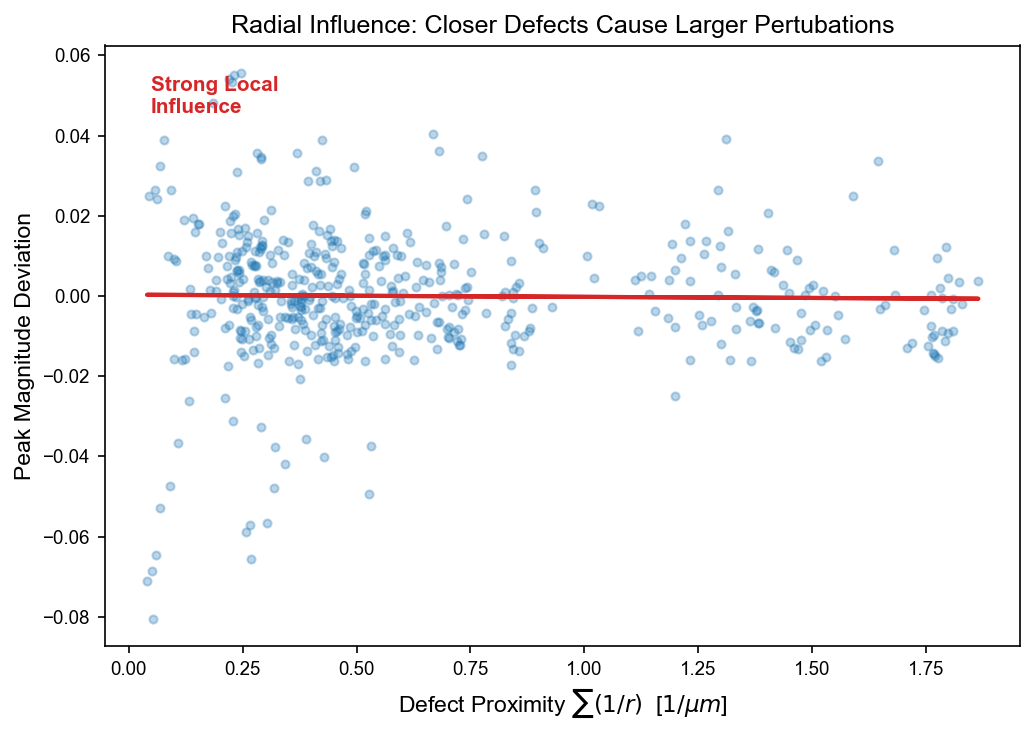

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

subset = df[df["n_total_defects"] > 0]
x = subset["sum_1_over_dist"]
y = subset["delta_peak_mag"]

ax.scatter(x, y, alpha=0.3, s=15, color="#1f77b4")
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color="#d62728", linewidth=2)

ax.set_xlabel(r"Defect Proximity $\sum (1/r)$  [$1/\mu m$]")
ax.set_ylabel("Peak Magnitude Deviation")
ax.set_title("Radial Influence: Closer Defects Cause Larger Pertubations")

ax.text(0.05, 0.95, "Strong Local\nInfluence", transform=ax.transAxes, va='top', fontweight='bold', color='#d62728')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Fig3_Radial_Influence.png"), bbox_inches="tight", dpi=300)
plt.show()

## 4. Macroscopic Field Maps (Figure 4)

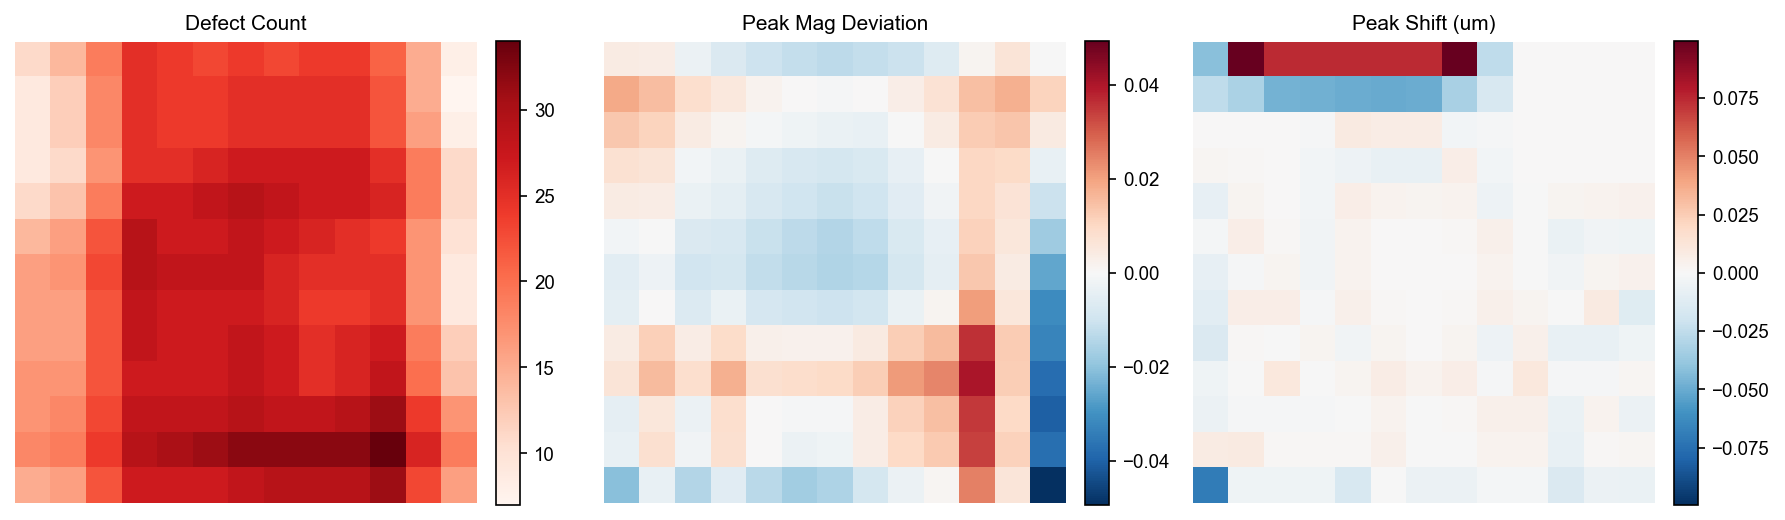

In [6]:
def plot_array_heatmap(ax, df_sub, value_col, title, cmap="viridis", vmin=None, vmax=None, center_diverging=False):
    grid = np.full((13, 13), np.nan)
    for _, row in df_sub.iterrows():
        i, j = int(row['local_i']), int(row['local_j'])
        grid[12-i, j] = row[value_col]
        
    if center_diverging:
        max_abs = max(abs(np.nanmin(grid)), abs(np.nanmax(grid)))
        if vmin is None: vmin = -max_abs
        if vmax is None: vmax = max_abs
        
    im = ax.imshow(grid, cmap=cmap, vmin=vmin, vmax=vmax, extent=[0, 21, 0, 21])
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    return im

target_array = "Array_1.0"
sub_df = df[df["array"] == target_array]
if len(sub_df) == 0: sub_df = df[df["array"] == df["array"].iloc[0]]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im1 = plot_array_heatmap(axes[0], sub_df, "n_total_defects", "Defect Count", cmap="Reds")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = plot_array_heatmap(axes[1], sub_df, "delta_peak_mag", "Peak Mag Deviation", cmap="RdBu_r", center_diverging=True)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = plot_array_heatmap(axes[2], sub_df, "delta_peak_wl", "Peak Shift (um)", cmap="RdBu_r", center_diverging=True)
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Fig4_Array_Fields.png"), bbox_inches="tight", dpi=300)
plt.show()

## 5. Model Validation (Figure 5)

Running CV...


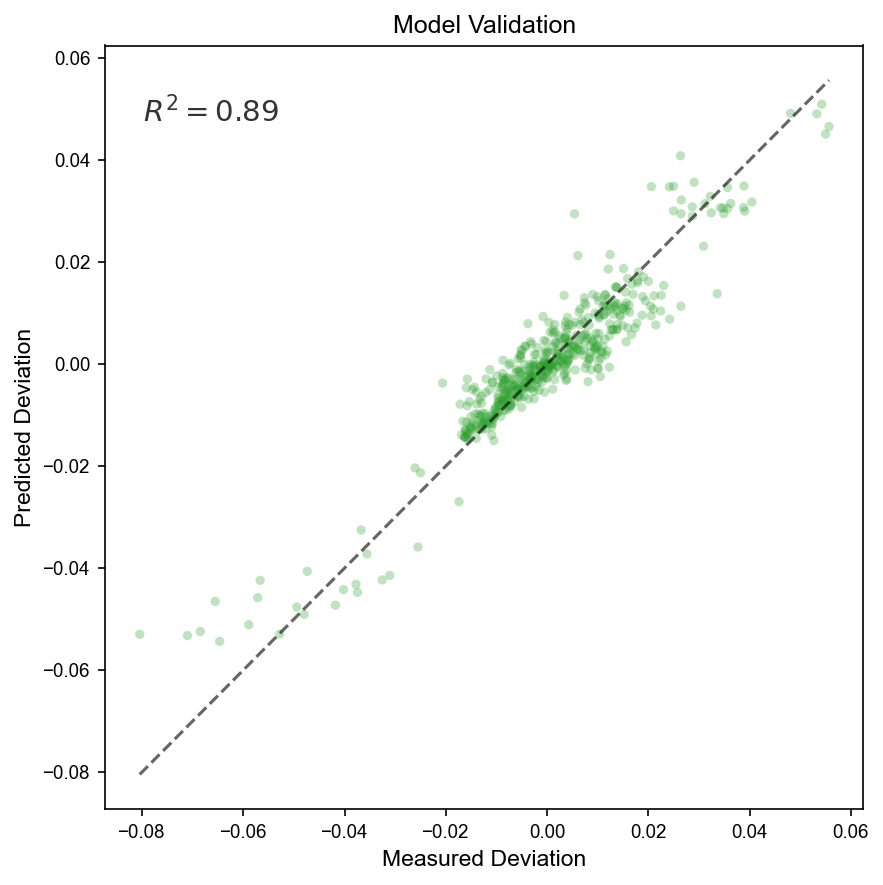

In [7]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X_val = df[features_cols].values
y_val = df[target].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
])

print("Running CV...")
y_pred = cross_val_predict(pipe, X_val, y_val, cv=kf)
r2 = r2_score(y_val, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_val, y_pred, alpha=0.3, color="#2ca02c", edgecolors='none', s=20)
min_val, max_val = min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], "--k", linewidth=1.5, alpha=0.6)

ax.text(0.05, 0.9, f"$R^2 = {r2:.2f}$", transform=ax.transAxes, fontsize=14, fontweight="bold", color="#333333")
ax.set_xlabel("Measured Deviation")
ax.set_ylabel("Predicted Deviation")
ax.set_title("Model Validation")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Fig5_ML_Parity.png"), bbox_inches="tight", dpi=300)
plt.show()